In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
# Image normalization
# Converts the image into a tesor and normalizes to acheive a mean of 0 and variance of 1
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# Download MNIST train and test set and normalize images
train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Define train and test dataloaders, used to get batches sequentially
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1024)

Image size torch.Size([28, 28]) 



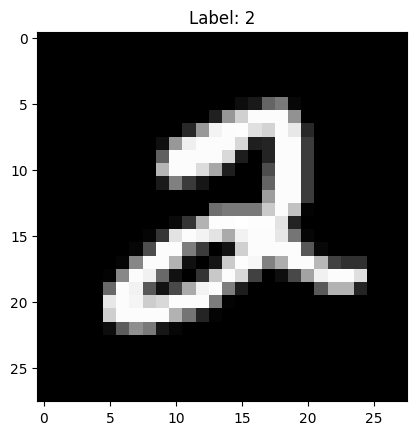

In [ ]:
img_index = 5
image = train_set[img_index][0].squeeze()
plt.imshow(image, cmap = 'binary_r')
plt.title(f"Label: {train_set[img_index][1]}")
print(f"Image size {image.shape} \n")

Image size torch.Size([28, 28]) 



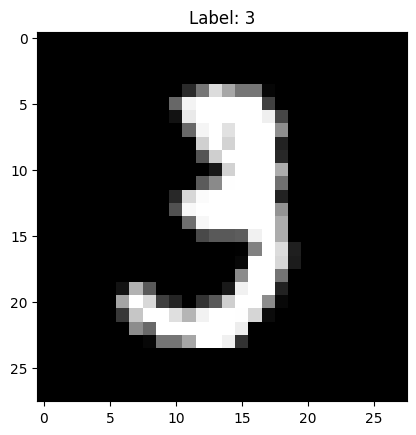

In [ ]:
img_index = 10
image = train_set[img_index][0].squeeze()
plt.imshow(image, cmap = 'binary_r')
plt.title(f"Label: {train_set[img_index][1]}")
print(f"Image size {image.shape} \n")

Image size torch.Size([28, 28]) 



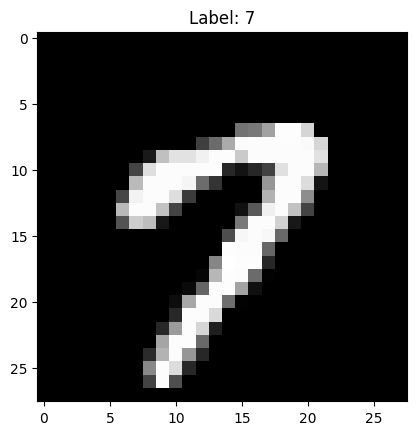

In [ ]:
img_index = 15
image = train_set[img_index][0].squeeze()
plt.imshow(image, cmap = 'binary_r')
plt.title(f"Label: {train_set[img_index][1]}")
print(f"Image size {image.shape} \n")

Task 2

In [ ]:
def conv2D(image, filters):
  num_filters, filter_size, _ = filters.shape
  y, x = image.shape

  K = (filter_size-1)//2

  y_pad = y + filter_size - 1
  x_pad = x + filter_size - 1
  result = torch.zeros((num_filters, y_pad, x_pad))
  result[:, K:y_pad-K, K:x_pad-K] = image
  final = torch.zeros((num_filters, y, x))

  for idx in range(num_filters):
        filt_i = filters[idx]
        # Iterate over the kernel entries (these are the filter taps AKA the parameters we are learning)
        for k in range(-K, K+1):
            for l in range(-K, K+1):
                # Shift the image vertically and then horizontally
                rolled_image = torch.roll(torch.roll(result[idx], -k, dims=0), -l, dims=1)
                # Multiply the kernel with the rolled image and sum the result
                final[idx] += rolled_image[K: K+y, K: K+x] * filt_i[k+K, l+K]

  return final

In [ ]:
class FilterBank(nn.Module):
  def __init__(self, num_filters, K):
      super(FilterBank, self).__init__()
      L = K * 2 + 1

      self.num_filters = num_filters
      self.filters = torch.zeros((num_filters, L, L))

  def forward(self, x):
    b, h, w = x.shape

    out = torch.zeros((b, self.num_filters, h, w))

    for i, img in enumerate(x):
      out[i] = conv2D(img, self.filters)

    return out

Task 3

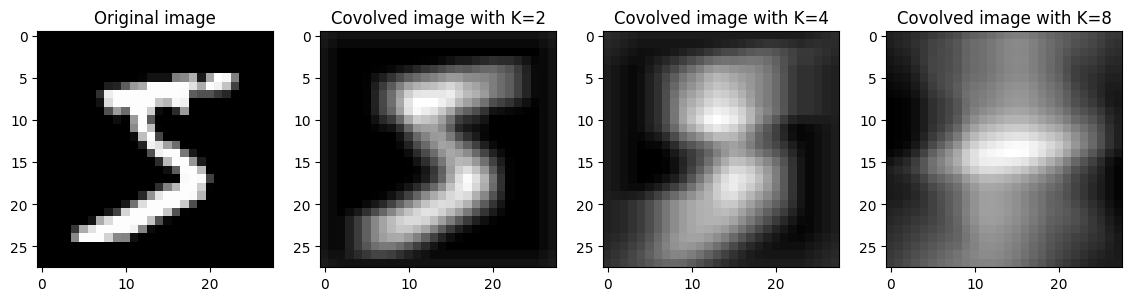

In [ ]:
img = train_set[0][0]

fig, ax = plt.subplots(1,4, figsize=(14,3.5))
ax[0].imshow(img.squeeze(), cmap = 'binary_r')
ax[0].set_title("Original image")

K_vals = [2,4,8]

for i, K in enumerate(K_vals):
  filt = FilterBank(num_filters = 1, K = K)
  filt.filters = torch.ones((1, 2*K+1, 2*K+1))*(1/(2*K+1)**2)
  out = filt(img)
  ax[i+1].imshow(out.squeeze(), cmap = 'binary_r')
  ax[i+1].set_title(f"Covolved image with K={K}")

Task 4

In [ ]:
# Grab batch of 100 images from the dataset
imgs = next(iter(train_loader))[0][:100]

# Perform convolution with function from torch
K = 8
conv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 2*K+1, padding = 'same', bias = False)
# Time convolution
start = time.time()
out = conv(imgs)
end = time.time()

print(f"PyTorch's Convolution took: {end-start:.3f} seconds")

# Perform convolution with your function
filterbank = FilterBank(num_filters = 1, K = 8)
# Initialize filters with the torch initialization
filterbank.filters = conv.weight.squeeze(0)

start = time.time()
out_manual = filterbank(imgs.squeeze())
end = time.time()
print(f"Manual Convolution took: {end-start:.3f} seconds")

# Check that outputs match
print(f"Manual convolution and torch convolution output the same tensor: {torch.allclose(out_manual, out, atol = 1e-5)}")

PyTorch's Convolution took: 0.226 seconds
Manual Convolution took: 3.156 seconds
Manual convolution and torch convolution output the same tensor: True


Task 5

In [ ]:
class FilterBank(nn.Module):
    def __init__(self, num_filters, K):
        super(FilterBank, self).__init__()

        # In the MNIST dataset each class corresponds to a digit
        num_classes = 10

        # Filter Bank with num_filter filters and num_taps taps
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = num_filters, kernel_size = 2*K+1, stride = 1, padding = 'same')

        # Linear layer. This layer takes our num_filters number of output channels and transforms it into an output with dimension num_classes
        self.linear = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        # Pass through filter bank
        x = self.conv1(x)

        # Compute energy of each output feature
        # Notice that this condenses filter bank output into a vector of shape (b, num_filters)
        x = torch.sum( x**2, dim=(2,3) )

        # Linear map between feature energies and class scores
        x = self.linear(x)
        return x

Task 6

In [ ]:
model = FilterBank(num_filters = 30, K = 1)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
cross_entropy = nn.CrossEntropyLoss()

In [ ]:
model.train()

loss_evol = []
num_epochs = 10
for epoch in range(num_epochs):
    loss_epoch = 0.
    acc_epoch = 0.

    for data, target in train_loader:
        # Clear gradients of previous batch
        optimizer.zero_grad()

        # Compute batch predictions
        output = model(data)

        # Compute loss
        loss = cross_entropy(output, target)

        # Compute gradients of loss w respect to current params
        loss.backward()

        # Update params using SGD
        optimizer.step()

        # Accumulate batch losses
        loss_epoch += loss.item()

        # Accumulate correct predictions, highest score is predicted class.
        pred = output.argmax(dim=-1)
        acc_epoch += torch.sum(pred == target)

    loss_evol.append(loss_epoch/len(train_loader))
    # Print metrics
    print(f"Epoch: {epoch} \t Loss: {loss_epoch/len(train_loader):.3f} \t Acc: {acc_epoch*100/len(train_loader.dataset):.2f}")

Epoch: 0 	 Loss: 14.915 	 Acc: 30.45
Epoch: 1 	 Loss: 3.083 	 Acc: 40.38
Epoch: 2 	 Loss: 2.148 	 Acc: 44.95
Epoch: 3 	 Loss: 1.845 	 Acc: 46.97
Epoch: 4 	 Loss: 1.670 	 Acc: 48.65
Epoch: 5 	 Loss: 1.572 	 Acc: 49.59
Epoch: 6 	 Loss: 1.500 	 Acc: 50.37
Epoch: 7 	 Loss: 1.450 	 Acc: 51.01
Epoch: 8 	 Loss: 1.408 	 Acc: 51.61
Epoch: 9 	 Loss: 1.374 	 Acc: 52.29


In [ ]:
test_loss_evol = []
num_epochs = 10
for epoch in range(num_epochs):
    loss_epoch = 0.
    acc_epoch = 0.

    for data, target in test_loader:
        output = model(data)
        loss = cross_entropy(output, target)
        loss_epoch += loss.item()
        pred = output.argmax(dim=-1)
        acc_epoch += torch.sum(pred == target)

    loss_evol.append(loss_epoch/len(test_loader))
    # Print metrics
    print(f"Epoch: {epoch} \t Loss: {loss_epoch/len(test_loader):.3f} \t Acc: {acc_epoch*100/len(test_loader.dataset):.2f}")

Epoch: 0 	 Loss: 1.486 	 Acc: 50.00
Epoch: 1 	 Loss: 1.486 	 Acc: 50.00
Epoch: 2 	 Loss: 1.486 	 Acc: 50.00
Epoch: 3 	 Loss: 1.486 	 Acc: 50.00
Epoch: 4 	 Loss: 1.486 	 Acc: 50.00


KeyboardInterrupt: 